In [12]:
from functions import *

from tqdm import tqdm
import matplotlib.pyplot as plt

In [13]:
n = 5
m = RandomIsingModel(n)

In [14]:
def get_proposal_mat_quantum(m, gamma=0.7, t=1):
    '''Get a quantum proposal matrix for a given Ising model.'''
    H_zz = sum([-m.J_rescaled[i,j]*Z(i,n) @ Z(j,n) for i in range(n) for j in range(i+1,n)]) # note that the factor 1/2 is not needed here
    H_z = sum([-m.h_rescaled[i]*Z(i,n) for i in range(n)])
    H_x = sum([X(i,n) for i in range(n)])
    H = (1-gamma) *(H_zz + H_z) + gamma*H_x
    assert np.allclose(H.T, H), 'H must be symmetric.'
    
    proposal_mat = np.zeros((2**m.n, 2**m.n))
    for s in range(2**m.n):
        out_state = sparse_la.expm_multiply(-1j * H * t, get_basis_state(s,m.n))
        transitions = [np.abs(a)**2 for a in out_state]
        proposal_mat[:,s] = transitions

    assert is_stochastic(proposal_mat), 'Proposal matrix is not stochastic.'
    return proposal_mat

In [21]:
np.linspace(0.25, 0.6, num_gammas, endpoint=False)

array([0.25 , 0.285, 0.32 , 0.355, 0.39 , 0.425, 0.46 , 0.495, 0.53 ,
       0.565])

In [15]:
num_random_models = 20
num_temperatures = 10
num_gammas = 10

T_arr = np.geomspace(0.01, 100, num_temperatures)
gammas = np.linspace(0.25, 0.6, num_gammas)

delta_random_arr = np.zeros((num_temperatures, num_random_models))
delta_local_arr = np.zeros((num_temperatures, num_random_models))
delta_quantum_arr = np.zeros((num_temperatures, num_random_models, num_gammas))

for T_index in tqdm(range(num_temperatures)):
    T = T_arr[T_index]
    for i in range(num_random_models):
        m = RandomIsingModel(n)
        for gamma_index in range(num_gammas):
            gamma = gammas[gamma_index]

            proposal_mat_random = get_proposal_mat_random(m)
            P_random = get_transition_matrix(m, T, proposal_mat_random)
            delta_random = get_delta(P_random)
            delta_random_arr[T_index][i] = delta_random

            proposal_mat_local = get_proposal_mat_local(m)
            P_local = get_transition_matrix(m, T, proposal_mat_local)
            delta_local = get_delta(P_local)
            delta_local_arr[T_index][i] = delta_local

            proposal_mat_quantum = get_proposal_mat_quantum(m, gamma=gamma)
            P_quantum = get_transition_matrix(m, T, proposal_mat_quantum)
            delta_quantum = get_delta(P_quantum)
            delta_quantum_arr[T_index][i][gamma_index] = delta_quantum

100%|██████████| 10/10 [02:29<00:00, 14.96s/it]


In [16]:
delta_random_arr_avg = np.mean(delta_random_arr, axis=1)
delta_random_arr_std = np.std(delta_random_arr, axis=1)

delta_local_arr_avg = np.mean(delta_local_arr, axis=1)
delta_local_arr_std = np.std(delta_local_arr, axis=1)

delta_quantum_arr_avg = np.mean(delta_quantum_arr, axis=(1,2))
delta_quantum_arr_std = np.std(delta_quantum_arr, axis=(1,2))

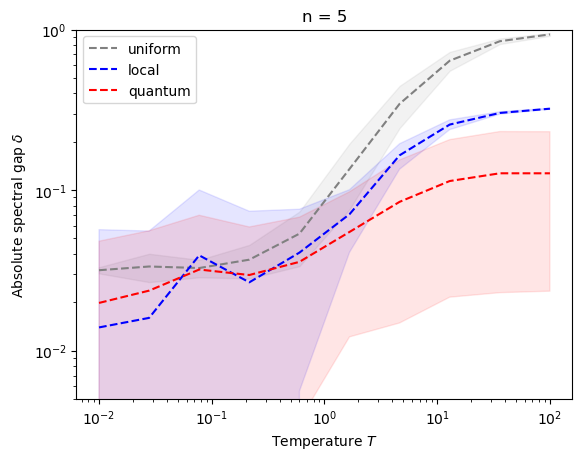

In [17]:
plt.plot(T_arr, delta_random_arr_avg, '--', color='grey', label = 'uniform')
plt.plot(T_arr, delta_local_arr_avg, '--', color='blue', label = 'local')
plt.plot(T_arr, delta_quantum_arr_avg, '--', color='red', label = 'quantum')

plt.fill_between(T_arr, 
                 delta_random_arr_avg-delta_random_arr_std, 
                 delta_random_arr_avg+delta_random_arr_std, 
                 color='grey',
                 alpha=0.1)
plt.fill_between(T_arr, 
                 delta_local_arr_avg-delta_local_arr_std, 
                 delta_local_arr_avg+delta_local_arr_std, 
                 color='blue',
                 alpha=0.1)
plt.fill_between(T_arr, 
                 delta_quantum_arr_avg-delta_quantum_arr_std, 
                 delta_quantum_arr_avg+delta_quantum_arr_std, 
                 color='red',
                 alpha=0.1)

plt.title(f'n = {n}')
plt.xlabel('Temperature $T$')
plt.ylabel('Absolute spectral gap $\delta$')
plt.ylim(0.005, 1)
plt.yscale('log')
plt.xscale('log')
plt.legend()

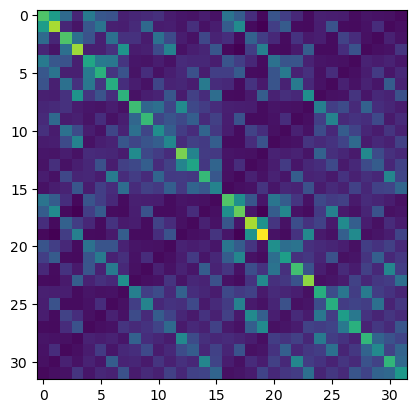

In [18]:
# TODO: What does the proposal probability actually mean? How is it related to the perturbative analysis? Does it have anything to do with how common the energy eigenvalue is?
m.T = 1
proposal_mat_quantum = get_proposal_mat_quantum(m)
plt.imshow(proposal_mat_quantum,  interpolation='nearest')

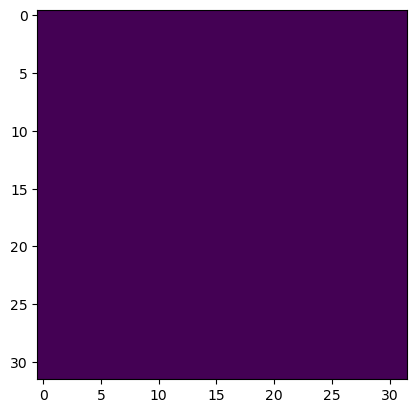

In [19]:
m.T = 1
proposal_mat_random = get_proposal_mat_random(m)
plt.imshow(proposal_mat_random,  interpolation='nearest')

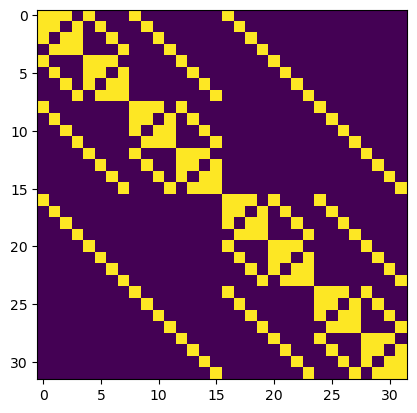

In [20]:
m.T = 1
proposal_mat_local = get_proposal_mat_local(m, hamming_radius=1)
plt.imshow(proposal_mat_local,  interpolation='nearest')